### This notebook estimates the maximum number of electrons per pixel the spaceX satellites would produce.\
Craig Lage - 18Dec19  I took Bo's notebook, removed the LSST DM requirement, 
and replaced it with Josh Meyer's Exposure Time Calculator.  Now only GalSim is required.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import galsim

In [2]:
# CCD parameters
# full_well for a 30s visit, in e-
# These are only used in the plots
full_well = 150e3  #typical for e2v sensors. ITL is typically 200k. We try to be conservative and use the smaller.
full_well2 = 100e3  #some sensors can be as low as 100K e-.
# Currently the bias offsets are not used.
bias_offset = 30e3
bias_offset_subtract = 0 #According to Steve R. and Aaron R., this should not be a factor

## We first determine what fraction of the flux will be in the center/brightest pixel
#### A satellite typically moves at 0.5 deg per sec. It is 4m wide and 550km high.
#### We'll make these variables so we can change them

In [3]:
size_in_m = 4.0
height_in_m = 550.0E3
fwhm = size_in_m / height_in_m / np.pi * 180 * 3600
print('FWHM = %.2f arcsec'%fwhm)

FWHM = 1.50 arcsec


In [4]:
#Assume it moves along pixel grid. The time its image center moves from one pixel center to the next is dt
pixel_scale = 0.2 # arcseconds
speed_in_deg_per_sec = 0.5
dt = pixel_scale / (speed_in_deg_per_sec*3600) # in seconds

nvisits = 1
filterlist = ['u', 'g', 'r', 'i', 'z', 'y']
exposure_time = 30.0


#### Approximate it as a source which appears at one pixel center for dt, then disappears from there, and instantly appears at the next pixel center for dt. During each dt, the source deposit a flux profile that is a Gaussian with FWHM of 1.5 arcsec.
So we are just overlapping Gaussians whose centers are 0.2 arcsec apart. Considering that the FWHM is much larger than pixel size, the top of the Gaussians are pretty flat. So this should be a pretty good approximation.
This slightly overestimates the flux, because having the Gaussian moving across the pixel in dt would yield a smaller flux for the pixel, compared to when the center of the Gaussian is overlapped with the pixel center during dt.

0.124736815648


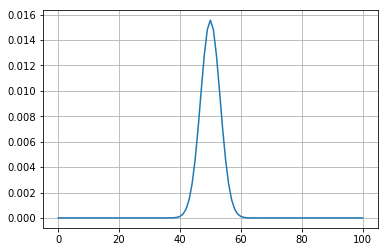

In [5]:
stamp_size = 101

psf = galsim.Gaussian(fwhm=fwhm)
img = galsim.ImageD(stamp_size, stamp_size, scale=pixel_scale)
psf = psf.withFlux(1) #unit flux
psf.drawImage(image=img)
ratio = sum(img.array[50,:])/np.sum(img.array)
plt.plot(img.array[50,:])
print(ratio) # This is the ratio of the peak to the total of the flux in time dt
plt.grid()

In [6]:
#what if the trail is 45 deg to the pixel grid?
# dt will be 1.414 time longer, would that give a larger ratio?
print(sum(np.diag(img.array))*1.414)
# it is the same. Bingo. That is it.

0.124718607098


### ETC calculator - modified by Craig Lage, but (hopefully) content is unchanged.

In [7]:
class ETC(object):
    def __init__(self, band, pixel_scale=None, stamp_size=None, threshold=0.0,
                 nvisits=None, visit_time=30.0, sky='Dark'):
        self.A = 319/9.6  # etendue / FoV. 
        self.pixel_scale = pixel_scale
        self.stamp_size = stamp_size
        self.threshold = threshold
        self.band = band
        if nvisits is None:
            nvisits = fiducial_nvisits[band]
        self.nvisits = nvisits
        self.visit_time =  visit_time
        self.exptime = self.nvisits * self.visit_time
        self.sky = self.sbar(band, sky) * self.exptime * self.pixel_scale**2
        self.sigma_sky = np.sqrt(self.sky)
        self.s0 = self.s0(band)
        self.bd = galsim.BaseDeviate(1)
        
    def s0(self, band):
        # zeropoints from DK notes in photons per second per pixel
        # should eventually compute these on the fly from filter throughput functions.
        s0 = {'u': self.A*0.732,
              'g': self.A*2.124,
              'r': self.A*1.681,
              'i': self.A*1.249,
              'z': self.A*0.862,
              'y': self.A*0.452}
        return s0[band]

    def sbar(self, band, sky):
        if sky == 'Bright':
            B = {'u': 17.7,
                 'g': 19.4,
                 'r': 19.7,
                 'i': 19.4,
                 'z': 18.2,
                 'y': 17.7}
        else:
            B = {'u': 22.8,
                 'g': 22.2,
                 'r': 21.3,
                 'i': 20.3,
                 'z': 19.1,
                 'y': 18.1}
        return self.s0(band) * 10**(-0.4*(B[band]-24.0))
        
    def draw(self, profile, mag, noise=False):
        img = galsim.ImageD(self.stamp_size, self.stamp_size, scale=self.pixel_scale)
        flux = self.s0 * 10**(-0.4*(mag - 24.0)) * self.exptime
        profile = profile.withFlux(flux)
        profile.drawImage(image=img)
        if noise:
            gd = galsim.GaussianNoise(self.bd, sigma=self.sigma_sky)
            img.addNoise(gd)
        return img

    def SNR(self, profile, mag):
        img = self.draw(profile, mag, noise=False)
        mask = img.array > (self.threshold * self.sigma_sky)
        imgsqr = img.array**2*mask
        signal = imgsqr.sum()
        noise = np.sqrt((imgsqr * self.sky).sum())
        return signal / noise

    def nphot(self, mag):
        return self.s0 * 10**(-0.4*(mag - 24.0)) * self.exptime

    def err(self, profile, mag):
        snr = self.SNR(profile, mag)
        return 2.5 / np.log(10) / snr

    def totalCounts(self, profile, mag, noise=True):
        img = self.draw(profile, mag, noise)
        return img.array.sum()


### Make peak electron counts vs. mag plot

for 5th mag, under Dark sky, band u, peak e per pixel = 11344
for 5th mag, under Dark sky, band g, peak e per pixel = 33104
for 5th mag, under Dark sky, band r, peak e per pixel = 26654
for 5th mag, under Dark sky, band i, peak e per pixel = 20710
for 5th mag, under Dark sky, band z, peak e per pixel = 16390
for 5th mag, under Dark sky, band y, peak e per pixel = 11079


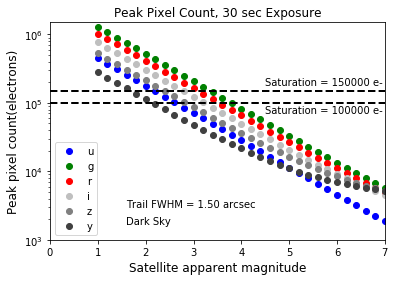

In [8]:
stamp_size = 11 # stamp size in pixels
colors = ['blue', 'green', 'red', '0.75', '0.50', '0.25']
d_plot = pd.DataFrame(index=filterlist, columns=['SatLimFromPlot'], dtype='float')
fig, ax = plt.subplots()
sky = 'Dark'
for i,f in enumerate(filterlist):
    mags = []
    npeaks = []
    etc = ETC(f, pixel_scale=pixel_scale, stamp_size=stamp_size, nvisits=nvisits, sky=sky, visit_time=dt)
    for m in range(31):
        mag = 1 + 0.2 * m
        mags.append(mag)
        # The sky below is for the full exposure time, while the object is just for dt.
        npeak = etc.totalCounts(psf, mag) * ratio + etc.sky * exposure_time / dt
        npeaks.append(npeak)
        if mag==5.0:
            print('for 5th mag, under %s sky, band %s, peak e per pixel = %.0f'%(sky,f,npeak))
    plt.scatter(mags, npeaks, label=f, color=colors[i])
    d_plot.SatLimFromPlot.loc[f] = mags[np.argmax(np.array(npeaks)<full_well)]
plt.title("Peak Pixel Count, %.0f sec Exposure"%exposure_time)
plt.plot([0,7.0],[full_well, full_well], ls = '--', lw = 2, color='black')
plt.text(4.5, full_well*1.20, "Saturation = %d e-"%full_well, color = 'black')
plt.plot([0,7.0],[full_well2, full_well2], ls = '--', lw = 2, color='black')
plt.text(4.5, full_well2*0.7, "Saturation = %d e-"%full_well2, color = 'black')
plt.text(0.3, 0.24, "Trail FWHM = %.2f arcsec"%fwhm, color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.18, "%s Sky"%sky, color = 'black', transform=fig.transFigure)
plt.legend()
plt.yscale('log')
plt.xlim(0,7.0)
plt.ylim(1e3, 1.5e6)
plt.xlabel('Satellite apparent magnitude', fontsize=12)
plt.ylabel('Peak pixel count(electrons)', fontsize=12);

### Now do the same thing for bright sky. 

for 5th mag, under Bright sky, band u, peak e per pixel = 20921
for 5th mag, under Bright sky, band g, peak e per pixel = 38520
for 5th mag, under Bright sky, band r, peak e per pixel = 29366
for 5th mag, under Bright sky, band i, peak e per pixel = 22651
for 5th mag, under Bright sky, band z, peak e per pixel = 20436
for 5th mag, under Bright sky, band y, peak e per pixel = 12919


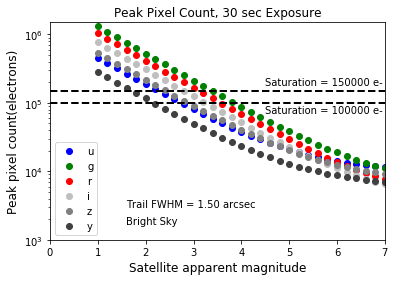

In [9]:
stamp_size = 11 # stamp size in pixels
colors = ['blue', 'green', 'red', '0.75', '0.50', '0.25']
d_plot = pd.DataFrame(index=filterlist, columns=['SatLimFromPlot'], dtype='float')
fig, ax = plt.subplots()
sky = 'Bright'
for i,f in enumerate(filterlist):
    mags = []
    npeaks = []
    etc = ETC(f, pixel_scale=pixel_scale, stamp_size=stamp_size, nvisits=nvisits, sky=sky, visit_time=dt)
    for m in range(31):
        mag = 1 + 0.2 * m
        mags.append(mag)
        # The sky below is for the full exposure time, while the object is just for dt.
        npeak = etc.totalCounts(psf, mag) * ratio + etc.sky * exposure_time / dt
        npeaks.append(npeak)
        if mag==5.0:
            print('for 5th mag, under %s sky, band %s, peak e per pixel = %.0f'%(sky,f,npeak))
    plt.scatter(mags, npeaks, label=f, color=colors[i])
    d_plot.SatLimFromPlot.loc[f] = mags[np.argmax(np.array(npeaks)<full_well)]
plt.title("Peak Pixel Count, %.0f sec Exposure"%exposure_time)
plt.plot([0,7.0],[full_well, full_well], ls = '--', lw = 2, color='black')
plt.text(4.5, full_well*1.20, "Saturation = %d e-"%full_well, color = 'black')
plt.plot([0,7.0],[full_well2, full_well2], ls = '--', lw = 2, color='black')
plt.text(4.5, full_well2*0.7, "Saturation = %d e-"%full_well2, color = 'black')
plt.text(0.3, 0.24, "Trail FWHM = %.2f arcsec"%fwhm, color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.18, "%s Sky"%sky, color = 'black', transform=fig.transFigure)
plt.legend()
plt.yscale('log')
plt.xlim(0,7.0)
plt.ylim(1e3, 1.5e6)
plt.xlabel('Satellite apparent magnitude', fontsize=12)
plt.ylabel('Peak pixel count(electrons)', fontsize=12);